Original Graph: 250 nodes, 24716 edges
K-hop Graph: 250 nodes, 24966 edges
Centralities recalculated on K-hop graph!
SIR simulation complete on K-hop graph!
Epoch 0, Loss: 0.6585
Epoch 10, Loss: 0.5184
Epoch 20, Loss: 0.5056
Epoch 30, Loss: 0.4963
Epoch 40, Loss: 0.4949
Epoch 50, Loss: 0.4941
Epoch 60, Loss: 0.4932
Epoch 70, Loss: 0.4923
Epoch 80, Loss: 0.4910
Epoch 90, Loss: 0.4891
Epoch 100, Loss: 0.4887
Epoch 110, Loss: 0.4855
Epoch 120, Loss: 0.4833
Epoch 130, Loss: 0.4810
Epoch 140, Loss: 0.4742
Epoch 150, Loss: 0.4723
Epoch 160, Loss: 0.4796
Epoch 170, Loss: 0.4625
Epoch 180, Loss: 0.4728
Epoch 190, Loss: 0.4543


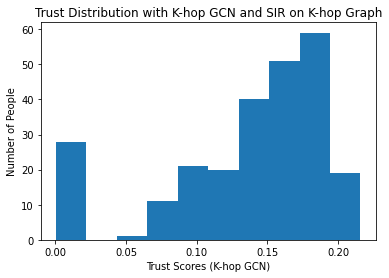

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random

# ✅ Load and Preprocess Data
df = pd.read_csv(r"/home/aryan/sop_fd/neeww(1).csv")
# Use a subset for prototyping
sample_size = int(len(df)*.1)
sampled_indices = random.sample(range(len(df)), sample_size)
df = df.iloc[sampled_indices].reset_index(drop=True)

# Create the graph and add nodes
G = nx.Graph()
num_users = len(df)
G.add_nodes_from(range(num_users))

# Cosine similarity calculation
feature_matrix = df.values
for i in range(num_users):
    for j in range(i + 1, num_users):
        vec1 = feature_matrix[i, 1:4]
        vec2 = feature_matrix[j, 1:4]
        similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

        if similarity >= 0.5:
            G.add_edge(i, j)

print(f"Original Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# ✅ K-hop Expansion
def get_k_hop_graph(G, k):
    """Expands the graph to K-hop neighbors."""
    k_hop_edges = set()

    for node in G.nodes():
        visited = set()
        queue = [(node, 0)]

        while queue:
            current, depth = queue.pop(0)

            if depth >= k:
                continue

            for neighbor in G.neighbors(current):
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, depth + 1))
                    k_hop_edges.add((node, neighbor))

    k_hop_graph = nx.Graph()
    k_hop_graph.add_edges_from(k_hop_edges)
    return k_hop_graph

# Expand to K-hop neighbors (e.g., K=2)
k = 4
G_k_hop = get_k_hop_graph(G, k)
print(f"K-hop Graph: {G_k_hop.number_of_nodes()} nodes, {G_k_hop.number_of_edges()} edges")

# ✅ Recalculate Centralities on K-hop Graph
centralities_k_hop = {
    'degree': nx.degree_centrality(G_k_hop),
    'betweenness': nx.betweenness_centrality(G_k_hop),
    'closeness': nx.closeness_centrality(G_k_hop),
    'eigenvector': nx.eigenvector_centrality(G_k_hop, max_iter=1000)
}
print("Centralities recalculated on K-hop graph!")

# ✅ Combine Features with K-hop Centralities
X_k_hop = np.array([[centralities_k_hop['degree'].get(i, 0),
                     centralities_k_hop['betweenness'].get(i, 0),
                     centralities_k_hop['closeness'].get(i, 0),
                     centralities_k_hop['eigenvector'].get(i, 0)]
                    for i in range(num_users)])

X_k_hop = np.concatenate([feature_matrix[:, [0]], X_k_hop], axis=1)

# ✅ SIR Simulation on K-hop Graph
def sir_simulation(G, patient_zero, beta=0.3, gamma=0.1, max_iter=50):
    """Simulates SIR model and returns max infected count."""
    states = {n: 'S' for n in G.nodes()}
    states[patient_zero] = 'I'
    infected_count = [1]

    for _ in range(max_iter):
        new_infections = 0
        recoveries = 0

        for node in list(G.nodes()):
            if states[node] == 'I':
                for neighbor in G.neighbors(node):
                    if states[neighbor] == 'S' and np.random.random() < beta:
                        states[neighbor] = 'I'
                        new_infections += 1

                if np.random.random() < gamma:
                    states[node] = 'R'
                    recoveries += 1

        infected_count.append(infected_count[-1] + new_infections - recoveries)

        if infected_count[-1] == 0:
            break

    return max(infected_count)

# Generate SIR labels on K-hop graph
sir_labels_k_hop = np.zeros(num_users)
for i in range(num_users):
    sir_labels_k_hop[i] = sir_simulation(G_k_hop, i)

print("SIR simulation complete on K-hop graph!")

# Assign labels based on SIR threshold
threshold = np.percentile(sir_labels_k_hop, 80)
y = (sir_labels_k_hop >= threshold).astype(int)

# ✅ Prepare Edge Index for PyTorch Geometric
expanded_edge_index = torch.tensor(list(G_k_hop.edges)).t().contiguous()

# Add K-hop indicator to features
X_with_k_hop = np.concatenate([X_k_hop, np.ones((X_k_hop.shape[0], 1))], axis=1)

# ✅ K-hop GCN Model with GraphSAGE
class TrustGraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=16, k=2):
        super(TrustGraphSAGE, self).__init__()
        self.k = k
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, hidden_dim)
        self.conv4 = SAGEConv(hidden_dim, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)

        # K-hop aggregation in multiple layers
        for _ in range(self.k - 1):
            x = self.conv2(x, edge_index)
            x = F.elu(x)

        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

# ✅ Train the K-hop GCN Model
# Convert data to tensors
features_k_hop = torch.tensor(X_with_k_hop, dtype=torch.float32)
labels_k_hop = torch.tensor(y, dtype=torch.long)

# Initialize the K-hop model
model = TrustGraphSAGE(input_dim=features_k_hop.shape[1], hidden_dim=16, k=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(200):
    model.train()
    optimizer.zero_grad()

    output = model(features_k_hop, expanded_edge_index)
    loss = F.nll_loss(output, labels_k_hop)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# ✅ Evaluate and Plot Trust Scores
# Evaluate the model
with torch.no_grad():
    model.eval()
    log_probs = model(features_k_hop, expanded_edge_index)
    influence_scores = torch.exp(log_probs[:, 1])

trust_scores_k_hop = influence_scores.numpy()

# Plot the trust score distribution
num, bins = np.histogram(trust_scores_k_hop, bins=10)
bin_width = bins[1] - bins[0]
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.bar(bin_centers, num, width=bin_width, align='center')
plt.xlabel("Trust Scores (K-hop GCN)")
plt.ylabel("Number of People")
plt.title("Trust Distribution with K-hop GCN and SIR on K-hop Graph")
plt.show()
